# 02 Data Exploration

This notebook explores and summarizes the combined FBref player datasets (2022–2025) to assess data quality and inform feature engineering for player value modeling. It covers:

* **Data loading:** Loads all interim-season CSVs and assigns them to global DataFrames
* **Multi-season merging:** Concatenates datasets by type (e.g. passing, shooting) across seasons with a `Season` column for time-aware analysis
* **Statistical summaries:** Prints key statistics, missing values, and outlier counts per dataset, focusing only on numeric columns with modeling relevance
* **Domain-specific notes:** Adds practical cleaning and transformation insights for each dataset, from minutes normalization to log-scaling and role-awareness
* **Feature relevance review:** Notes pitfalls like inflated rate stats, context leakage, sparse roles, and non-linear player valuation signals

> Output of this step is a set of combined, season-tagged datasets ready for cleaning and feature extraction. The summary insights guide what to transform, exclude, or enrich before modeling.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("..")

from pathlib import Path
import pandas as pd
import numpy as np

import ast

from fuzzywuzzy import fuzz

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Configure pandas to display full numbers instead of scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
team_name = "Valencia CF"

In [5]:
interim_data_directory = Path("..", "data", "interim", team_name, "fbref")
csv_files = interim_data_directory.glob("df_*.csv")

In [6]:
for csv_file in csv_files:
    df_name = csv_file.stem  # Remove ".csv"
    globals()[df_name] = pd.read_csv(csv_file)
    print(f"Loaded: {df_name}")

Loaded: df_player_defense_2324
Loaded: df_player_shooting_2324
Loaded: df_player_possession_2324
Loaded: df_player_passing_types_2223
Loaded: df_player_passing_types_2425
Loaded: df_player_passing_types_2324
Loaded: df_player_possession_2223
Loaded: df_player_possession_2425
Loaded: df_player_shooting_2425
Loaded: df_player_shooting_2223
Loaded: df_player_defense_2223
Loaded: df_player_defense_2425
Loaded: df_player_gca_2324
Loaded: df_player_stats_2223
Loaded: df_player_stats_2425
Loaded: df_player_passing_2324
Loaded: df_player_passing_2425
Loaded: df_player_passing_2223
Loaded: df_player_stats_2324
Loaded: df_player_gca_2425
Loaded: df_player_gca_2223


---

We combine season-specific datasets using `concat` to enable cross-season analysis, player tracking, and time-aware feature engineering in a unified structure.

In [7]:
def concat_player_dataframes_across_seasons(dataframe_prefix: str) -> pd.DataFrame:
    """Concatenates all player DataFrames with the given prefix across seasons and adds a Season column."""
    combined_dataframe: pd.DataFrame = pd.DataFrame()
    seasons: list[str] = ["2223", "2324", "2425"]

    for season_label in seasons:
        dataframe_variable_name: str = f"df_{dataframe_prefix}_{season_label}"
        if dataframe_variable_name not in globals():
            raise ValueError(f"DataFrame {dataframe_variable_name} not found in current environment.")

        single_season_dataframe: pd.DataFrame = globals()[dataframe_variable_name].copy()
        single_season_dataframe["Season"] = season_label
        combined_dataframe = pd.concat([combined_dataframe, single_season_dataframe], ignore_index=True)

    return combined_dataframe

In [8]:
dataframe_prefixes: list[str] = [
    "player_stats",
    "player_shooting",
    "player_passing",
    "player_passing_types",
    "player_gca",
    "player_defense",
    "player_possession"
]

combined_dataframes: dict[str, pd.DataFrame] = {}

for prefix in dataframe_prefixes:
    combined_name: str = f"df_combined_{prefix}"
    combined_dataframes[combined_name] = concat_player_dataframes_across_seasons(prefix)
    print(f"Combined: {combined_name}")

Combined: df_combined_player_stats
Combined: df_combined_player_shooting
Combined: df_combined_player_passing
Combined: df_combined_player_passing_types
Combined: df_combined_player_gca
Combined: df_combined_player_defense
Combined: df_combined_player_possession


---

In [9]:
def summarize_dataframe_statistics(dataframe: pd.DataFrame, dataframe_name: str) -> None:
    print(f"\n--- Summary: {dataframe_name} ---")

    # Columns to exclude from summary
    excluded_columns: set[str] = {"Player", "Nation", "Pos", "Matches", "Season"}

    # Filtered DataFrame
    columns_to_analyze: list[str] = [
        column_name for column_name in dataframe.columns
        if column_name not in excluded_columns and pd.api.types.is_numeric_dtype(dataframe[column_name])
    ]
    filtered_dataframe: pd.DataFrame = dataframe[columns_to_analyze]

    # Missing values
    missing_total: pd.Series = filtered_dataframe.isna().sum()
    missing_percent: pd.Series = (missing_total / len(filtered_dataframe)) * 100
    missing_summary: pd.DataFrame = pd.concat([missing_total, missing_percent], axis=1)
    missing_summary.columns = ['Missing Values', '% Missing']
    missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

    if not missing_summary.empty:
        print("\nMissing Values (Total and %):")
        display(missing_summary.sort_values('% Missing', ascending=False).T)

    # Descriptive statistics
    print("\nDescriptive Statistics:")
    display(filtered_dataframe.describe().transpose())

    # Outlier detection
    for column_name in filtered_dataframe.columns:
        series = filtered_dataframe[column_name]
        if series.std() == 0 or series.isna().all():
            continue
        z_scores = (series - series.mean()) / series.std()
        outlier_count = (z_scores.abs() > 3).sum()
        if outlier_count > 0:
            print(f"Outliers in {column_name}: {outlier_count} rows > 3 std deviations")

In [10]:
# Run summary for all combined DataFrames
for dataframe_name, dataframe_object in combined_dataframes.items():
    summarize_dataframe_statistics(dataframe_object, dataframe_name)


--- Summary: df_combined_player_stats ---

Missing Values (Total and %):


,Min,PrgC,npxG.1,xG+xAG,xAG.1,xG.1,G+A-PK,G-PK.1,G+A.1,Ast.1,Gls.1,PrgR,PrgP,npxG+xAG,90s,xAG,npxG,xG,CrdR,CrdY,PKatt,PK,G-PK,G+A,Ast,Gls,npxG+xAG.1
Missing Values,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00,25.00
% Missing,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83,20.83



Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Age,120.00,23.18,3.99,15.00,20.00,22.50,25.00,35.00
MP,120.00,16.80,14.12,0.00,1.00,16.50,30.25,38.00
Starts,120.00,31.35,89.87,0.00,0.00,7.00,24.00,418.00
Min,95.00,1401.43,1132.04,7.00,362.00,1315.00,2245.00,3420.00
90s,95.00,15.57,12.58,0.10,4.00,14.60,24.90,38.00
Gls,95.00,4.01,10.53,0.00,0.00,1.00,2.00,51.00
Ast,95.00,2.62,7.22,0.00,0.00,0.00,2.00,38.00
G+A,95.00,6.63,17.60,0.00,0.00,1.00,4.00,89.00
G-PK,95.00,3.52,9.40,0.00,0.00,0.00,2.00,45.00
PK,95.00,0.49,1.48,0.00,0.00,0.00,0.00,8.00


Outliers in Starts: 6 rows > 3 std deviations
Outliers in Gls: 6 rows > 3 std deviations
Outliers in Ast: 4 rows > 3 std deviations
Outliers in G+A: 6 rows > 3 std deviations
Outliers in G-PK: 5 rows > 3 std deviations
Outliers in PK: 5 rows > 3 std deviations
Outliers in PKatt: 4 rows > 3 std deviations
Outliers in CrdY: 5 rows > 3 std deviations
Outliers in CrdR: 2 rows > 3 std deviations
Outliers in xG: 6 rows > 3 std deviations
Outliers in npxG: 6 rows > 3 std deviations
Outliers in xAG: 6 rows > 3 std deviations
Outliers in npxG+xAG: 6 rows > 3 std deviations
Outliers in PrgC: 5 rows > 3 std deviations
Outliers in PrgP: 6 rows > 3 std deviations
Outliers in PrgR: 6 rows > 3 std deviations
Outliers in Gls.1: 4 rows > 3 std deviations
Outliers in Ast.1: 4 rows > 3 std deviations
Outliers in G+A.1: 4 rows > 3 std deviations
Outliers in G-PK.1: 5 rows > 3 std deviations
Outliers in G+A-PK: 4 rows > 3 std deviations
Outliers in xG.1: 6 rows > 3 std deviations
Outliers in xAG.1: 5 rows 

,G/SoT,SoT%,G/Sh,Dist,npxG/Sh
Missing Values,25.00,13.00,13.00,13.00,13.00
% Missing,26.32,13.68,13.68,13.68,13.68



Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Age,95.00,23.57,3.70,16.00,21.00,23.00,26.00,35.00
90s,95.00,15.57,12.58,0.10,4.00,14.60,24.90,38.00
Gls,95.00,4.01,10.53,0.00,0.00,1.00,2.00,51.00
Sh,95.00,38.73,98.16,0.00,3.00,10.00,21.50,480.00
SoT,95.00,12.61,33.00,0.00,0.00,2.00,7.00,154.00
SoT%,82.00,27.68,16.64,0.00,16.70,30.20,36.90,66.70
Sh/90,95.00,1.80,2.70,0.00,0.40,0.89,2.00,12.63
SoT/90,95.00,0.56,0.93,0.00,0.00,0.23,0.66,4.05
G/Sh,82.00,0.07,0.09,0.00,0.00,0.04,0.10,0.50
G/SoT,70.00,0.25,0.26,0.00,0.00,0.25,0.38,1.00


Outliers in Age: 1 rows > 3 std deviations
Outliers in Gls: 6 rows > 3 std deviations
Outliers in Sh: 6 rows > 3 std deviations
Outliers in SoT: 6 rows > 3 std deviations
Outliers in Sh/90: 6 rows > 3 std deviations
Outliers in SoT/90: 5 rows > 3 std deviations
Outliers in G/Sh: 1 rows > 3 std deviations
Outliers in FK: 4 rows > 3 std deviations
Outliers in PK: 5 rows > 3 std deviations
Outliers in PKatt: 4 rows > 3 std deviations
Outliers in xG: 6 rows > 3 std deviations
Outliers in npxG: 6 rows > 3 std deviations
Outliers in npxG/Sh: 2 rows > 3 std deviations
Outliers in G-xG: 2 rows > 3 std deviations
Outliers in np:G-xG: 2 rows > 3 std deviations

--- Summary: df_combined_player_passing ---

Missing Values (Total and %):


,Cmp%.3,Cmp%.2
Missing Values,4.00,1.00
% Missing,4.21,1.05



Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Age,95.00,23.57,3.70,16.00,21.00,23.00,26.00,35.00
90s,95.00,15.57,12.58,0.10,4.00,14.60,24.90,38.00
Cmp,95.00,1306.16,3376.12,2.00,86.00,387.00,799.50,16672.00
Att,95.00,1673.57,4291.09,4.00,128.00,482.00,1071.00,20730.00
Cmp%,95.00,74.20,10.63,40.00,70.15,75.50,80.40,100.00
TotDist,95.00,23320.84,60549.11,27.00,1445.00,5750.00,15090.00,302306.00
PrgDist,95.00,8427.72,22007.85,3.00,352.50,1857.00,5211.00,108756.00
Cmp.1,95.00,588.94,1510.87,1.00,49.00,161.00,370.00,7313.00
Att.1,95.00,670.15,1714.35,1.00,56.00,202.00,420.00,8278.00
Cmp%.1,95.00,86.33,9.05,53.30,82.35,87.90,90.95,100.00


Outliers in Age: 1 rows > 3 std deviations
Outliers in Cmp: 6 rows > 3 std deviations
Outliers in Att: 6 rows > 3 std deviations
Outliers in Cmp%: 2 rows > 3 std deviations
Outliers in TotDist: 6 rows > 3 std deviations
Outliers in PrgDist: 6 rows > 3 std deviations
Outliers in Cmp.1: 6 rows > 3 std deviations
Outliers in Att.1: 6 rows > 3 std deviations
Outliers in Cmp%.1: 2 rows > 3 std deviations
Outliers in Cmp.2: 6 rows > 3 std deviations
Outliers in Att.2: 6 rows > 3 std deviations
Outliers in Cmp%.2: 2 rows > 3 std deviations
Outliers in Cmp.3: 6 rows > 3 std deviations
Outliers in Att.3: 6 rows > 3 std deviations
Outliers in Ast: 4 rows > 3 std deviations
Outliers in xAG: 6 rows > 3 std deviations
Outliers in xA: 5 rows > 3 std deviations
Outliers in A-xAG: 1 rows > 3 std deviations
Outliers in KP: 6 rows > 3 std deviations
Outliers in 1/3: 5 rows > 3 std deviations
Outliers in PPA: 5 rows > 3 std deviations
Outliers in CrsPA: 4 rows > 3 std deviations
Outliers in PrgP: 6 rows 

,count,mean,std,min,25%,50%,75%,max
Age,95.00,23.57,3.70,16.00,21.00,23.00,26.00,35.00
90s,95.00,15.57,12.58,0.10,4.00,14.60,24.90,38.00
Att,95.00,1673.57,4291.09,4.00,128.00,482.00,1071.00,20730.00
Live,95.00,1483.95,3818.22,4.00,100.00,417.00,897.00,18759.00
Dead,95.00,182.16,461.96,0.00,8.00,33.00,89.50,2007.00
FK,95.00,51.92,130.90,0.00,0.00,8.00,33.50,570.00
TB,95.00,4.28,12.38,0.00,0.00,0.00,2.00,78.00
Sw,95.00,13.34,35.00,0.00,0.00,3.00,9.50,167.00
Crs,95.00,69.25,176.22,0.00,1.00,6.00,46.50,924.00
TI,95.00,78.61,205.60,0.00,0.00,2.00,21.50,868.00


Outliers in Age: 1 rows > 3 std deviations
Outliers in Att: 6 rows > 3 std deviations
Outliers in Live: 6 rows > 3 std deviations
Outliers in Dead: 6 rows > 3 std deviations
Outliers in FK: 6 rows > 3 std deviations
Outliers in TB: 3 rows > 3 std deviations
Outliers in Sw: 5 rows > 3 std deviations
Outliers in Crs: 4 rows > 3 std deviations
Outliers in TI: 6 rows > 3 std deviations
Outliers in CK: 5 rows > 3 std deviations
Outliers in In: 5 rows > 3 std deviations
Outliers in Out: 4 rows > 3 std deviations
Outliers in Str: 3 rows > 3 std deviations
Outliers in Cmp: 6 rows > 3 std deviations
Outliers in Off: 6 rows > 3 std deviations
Outliers in Blocks: 6 rows > 3 std deviations

--- Summary: df_combined_player_gca ---

Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Age,95.00,23.57,3.70,16.00,21.00,23.00,26.00,35.00
90s,95.00,15.57,12.58,0.10,4.00,14.60,24.90,38.00
SCA,95.00,69.09,174.42,0.00,6.00,15.00,44.50,859.00
SCA90,95.00,2.96,4.58,0.00,0.65,1.81,2.75,22.61
PassLive,95.00,49.35,124.04,0.00,4.00,12.00,31.50,607.00
PassDead,95.00,6.85,18.23,0.00,0.00,0.00,2.50,88.00
TO,95.00,3.87,10.18,0.00,0.00,0.00,3.00,59.00
Sh,95.00,3.79,10.25,0.00,0.00,1.00,2.50,53.00
Fld,95.00,3.86,10.01,0.00,0.00,0.00,2.00,51.00
Def,95.00,1.37,3.39,0.00,0.00,0.00,1.00,17.00


Outliers in Age: 1 rows > 3 std deviations
Outliers in SCA: 6 rows > 3 std deviations
Outliers in SCA90: 6 rows > 3 std deviations
Outliers in PassLive: 6 rows > 3 std deviations
Outliers in PassDead: 6 rows > 3 std deviations
Outliers in TO: 5 rows > 3 std deviations
Outliers in Sh: 4 rows > 3 std deviations
Outliers in Fld: 5 rows > 3 std deviations
Outliers in Def: 4 rows > 3 std deviations
Outliers in GCA: 6 rows > 3 std deviations
Outliers in GCA90: 5 rows > 3 std deviations
Outliers in PassLive.1: 5 rows > 3 std deviations
Outliers in PassDead.1: 3 rows > 3 std deviations
Outliers in TO.1: 3 rows > 3 std deviations
Outliers in Sh.1: 4 rows > 3 std deviations
Outliers in Fld.1: 5 rows > 3 std deviations
Outliers in Def.1: 3 rows > 3 std deviations

--- Summary: df_combined_player_defense ---

Missing Values (Total and %):


,Tkl%
Missing Values,12.00
% Missing,12.63



Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Age,95.00,23.57,3.70,16.00,21.00,23.00,26.00,35.00
90s,95.00,15.57,12.58,0.10,4.00,14.60,24.90,38.00
Tkl,95.00,61.92,155.04,0.00,4.00,18.00,41.00,678.00
TklW,95.00,37.82,94.34,0.00,2.00,12.00,24.50,428.00
Def_3rd,95.00,31.25,78.10,0.00,1.00,8.00,19.00,354.00
Mid_3rd,95.00,23.21,58.94,0.00,1.00,7.00,14.00,291.00
Att_3rd,95.00,7.45,18.89,0.00,0.00,3.00,4.50,88.00
Tkl.1,95.00,29.52,74.12,0.00,2.00,9.00,18.50,321.00
Att,95.00,57.45,144.23,0.00,4.50,17.00,39.00,659.00
Tkl%,83.00,53.63,22.58,0.00,39.25,54.50,66.70,100.00


Outliers in Age: 1 rows > 3 std deviations
Outliers in Tkl: 6 rows > 3 std deviations
Outliers in TklW: 6 rows > 3 std deviations
Outliers in Def_3rd: 6 rows > 3 std deviations
Outliers in Mid_3rd: 6 rows > 3 std deviations
Outliers in Att_3rd: 6 rows > 3 std deviations
Outliers in Tkl.1: 6 rows > 3 std deviations
Outliers in Att: 6 rows > 3 std deviations
Outliers in Lost: 5 rows > 3 std deviations
Outliers in Blocks: 6 rows > 3 std deviations
Outliers in Sh: 5 rows > 3 std deviations
Outliers in Pass: 6 rows > 3 std deviations
Outliers in Int: 6 rows > 3 std deviations
Outliers in Tkl+Int: 6 rows > 3 std deviations
Outliers in Clr: 4 rows > 3 std deviations
Outliers in Err: 4 rows > 3 std deviations

--- Summary: df_combined_player_possession ---

Missing Values (Total and %):


,Succ%,Tkld%
Missing Values,15.00,15.00
% Missing,15.79,15.79



Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Age,95.00,23.57,3.70,16.00,21.00,23.00,26.00,35.00
90s,95.00,15.57,12.58,0.10,4.00,14.60,24.90,38.00
Touches,95.00,2068.42,5276.52,4.00,146.00,620.00,1251.50,24786.00
Def_Pen,95.00,211.44,558.05,0.00,6.00,24.00,75.00,2406.00
Def_3rd,95.00,672.55,1724.22,0.00,25.50,144.00,395.00,7654.00
Mid_3rd,95.00,917.60,2366.41,0.00,42.50,237.00,561.00,11522.00
Att_3rd,95.00,498.35,1269.13,0.00,31.50,117.00,317.50,6255.00
Att_Pen,95.00,66.95,172.75,0.00,5.50,16.00,39.00,822.00
Live,95.00,2067.75,5274.85,4.00,146.00,620.00,1251.50,24780.00
Att,95.00,63.95,162.43,0.00,2.50,14.00,38.50,747.00


Outliers in Age: 1 rows > 3 std deviations
Outliers in Touches: 6 rows > 3 std deviations
Outliers in Def_Pen: 6 rows > 3 std deviations
Outliers in Def_3rd: 6 rows > 3 std deviations
Outliers in Mid_3rd: 6 rows > 3 std deviations
Outliers in Att_3rd: 6 rows > 3 std deviations
Outliers in Att_Pen: 6 rows > 3 std deviations
Outliers in Live: 6 rows > 3 std deviations
Outliers in Att: 6 rows > 3 std deviations
Outliers in Succ: 5 rows > 3 std deviations
Outliers in Tkld: 6 rows > 3 std deviations
Outliers in Carries: 6 rows > 3 std deviations
Outliers in TotDist: 6 rows > 3 std deviations
Outliers in PrgDist: 6 rows > 3 std deviations
Outliers in PrgC: 5 rows > 3 std deviations
Outliers in 1/3: 6 rows > 3 std deviations
Outliers in CPA: 6 rows > 3 std deviations
Outliers in Mis: 6 rows > 3 std deviations
Outliers in Dis: 6 rows > 3 std deviations
Outliers in Rec: 6 rows > 3 std deviations
Outliers in PrgR: 6 rows > 3 std deviations


NOTE

##### `df_combined_player_stats`

* The `90s` column is really important. If it's low, most stats won't mean much. Probably best to filter out players with too little play time.
* Age needs standardizing. Might be useful to transform it since player value doesn't increase linearly with age. Peak is usually mid-20s.
* Position isn't in this dataset but should definitely be added again later, maybe using one-hot or some position grouping.
* Stats like goals, assists or penalties have high variance and a lot of zeros. Could make sense to log-transform or put into bins.
* There's no info about team strength or player role, which could mess with value predictions if we don’t handle it carefully.

##### `df_combined_player_shooting`

* Most features here are per 90 minutes. Only makes sense to use them if the player actually played enough.
* Penalty stats are biased towards certain roles. Need to keep that in mind.
* Some advanced stats like `npxG` might have missing values. Should either fill them or flag them.
* Watch out for overperformance in ratios like `G/Sh` or `G/SoT`. Could just be randomness.
* Might be useful to calculate how much a player is over- or underperforming their xG.

##### `df_combined_player_passing`

* Pass completion percentage doesn't say much if a player barely passed the ball. Better to ignore low-attempt cases.
* Would be helpful to break down passing types (short, medium, long) to get a clearer picture.
* We can use progressive passes and final third passes to estimate passing risk or intent.
* Raw pass counts should probably be scaled by minutes.

##### `df_combined_player_passing_types`

* Some of these stats are very sparse and depend a lot on position. Need to be careful here or just fill with zeros.
* Could help identify roles, like fullbacks who cross a lot or midfielders who switch play.
* Might need to log or bin a few columns because of skewed distributions.

##### `df_combined_player_gca`

* GCA and SCA totals are just raw counts, so they really depend on minutes. Need to normalize.
* There’s a chance to use some columns to group players by creative style (e.g., dribbling vs. passing).
* These features could be strong signals for value, but probably a bit noisy too.

##### `df_combined_player_defense`

* Tackle and block counts can say more about team tactics than about player quality. So could be misleading.
* Use tackle win rate or efficiency stats instead of just totals.
* Errors or possessions lost can actually be higher for important players. Not always a bad sign.
* Could be worth clustering defensive styles based on these columns.

##### `df_combined_player_possession`

* Carries and touches give you a sense of how involved a player is with the ball.
* Miscontrols or times dispossessed often go up with involvement. Should divide these by touches or carries.
* Useful to combine with other datasets to understand if a player is just busy or actually efficient.

#### General Notes

* Normalize all count stats by minutes played, otherwise comparisons are off.
* Handle missing values with care. Many of them are probably role-related, not random.
* Make sure to avoid using future performance when predicting current or future value. Watch out for leakage.
* Use the `Season` column when doing train-test splits, especially if you're doing time-based modeling.


### Additional thoughts and considerations

* Add team strength data like league position, team Elo or average xG. Stats can look inflated or deflated depending on the club
* Consider player role and system. A player in a high pressing team or possession-heavy system will show different patterns
* Contract info would be useful. Years left, salary, or buyout clauses can influence market value
* Transfer history and rumors can help. Past fees and interest from other clubs can shift value quickly
* National team appearances are a good signal. Being called up regularly usually reflects higher reputation
* Split minutes by competition. Performing in Champions League is not the same as domestic league games
* Add injury history or availability data. Players missing many games are harder to value based on stats alone
* Recent form compared to season average can show if a player is trending up or down
* External ratings like Transfermarkt or maybe SofaScore can give a proxy for public or expert perception
* Social media or media coverage might help as an additional signal. More exposure can increase market attention
* Creating player similarity groups might help compare profiles and estimate expected value range

---

## Valencia Market Value Data Exploration
(built with third party scraper, before building our own)

This first section explores the data and the structure of the data.

In [11]:
valencia_market_value_dataframe = pd.read_csv('../data/raw/Valencia CF/transfermarkt/valencia_market_value_22_25.csv')

display(valencia_market_value_dataframe.head())
print("Dataset shape:", valencia_market_value_dataframe.shape)

,#,Player,Age,Current club,Market value,Nat.,Season,Contract
0,25.00,"['Giorgi Mamardashvili', 'Goalkeeper']",22,Valencia CF,€25.00m,Georgia,2022,NaN
1,23.00,"['Jaume Doménech', 'Goalkeeper']",32,Valencia CF,€1.00m,Spain,2022,NaN
2,1.00,"['Iago Herrerín', 'Goalkeeper']",35,Sestao River,€500k,Spain,2022,NaN
3,42.00,"['Emilio Bernad', 'Goalkeeper']",23,Racing Ferrol,€300k,Spain,2022,NaN
4,13.00,"['Cristian Rivero', 'Goalkeeper']",25,Albacete Balompié,€200k,Spain,2022,NaN


Dataset shape: (102, 8)


In [12]:
valencia_market_value_dataframe.Season.value_counts()

Season
2022    40
2023    36
2024    26
Name: count, dtype: int64

In [13]:
valencia_market_value_dataframe[['Name', 'Position']] = valencia_market_value_dataframe['Player'].apply(
    lambda x: pd.Series(ast.literal_eval(x))
)
valencia_market_value_dataframe.rename(columns={'Nat.': 'Nationality'}, inplace=True)

# Parse market value to float in euros
def parse_value(val: str) -> float | None:
    if isinstance(val, str):
        val = val.replace('€', '').replace(',', '').strip().lower()
        if 'm' in val:
            return float(val.replace('m', '')) * 1_000_000
        elif 'k' in val:
            return float(val.replace('k', '')) * 1_000
    return None

valencia_market_value_dataframe['MarketValueEuro'] = valencia_market_value_dataframe['Market value'].apply(parse_value)

# Clean dataframe (fix inplace issue here)
df_clean = valencia_market_value_dataframe[[
    '#', 'Name', 'Position', 'Age', 'Nationality', 'Current club', 'Season', 'MarketValueEuro'
]].rename(columns={'#': 'Rank'}).dropna(subset=['MarketValueEuro', 'Season'])

# Ensure Season is string
df_clean['Season'] = df_clean['Season'].astype(str)

# Normalize Nationality column
df_clean['Nationality'] = df_clean['Nationality'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
)

# Create column for primary nationality only
df_clean['PrimaryNationality'] = df_clean['Nationality'].apply(
    lambda x: x[0] if isinstance(x, list) else x
)

# Explode for all nationalities if needed (optional)
df_nationality_exploded = df_clean.copy()
df_nationality_exploded['Nationality'] = df_nationality_exploded['Nationality'].apply(
    lambda x: x if isinstance(x, list) else [x]
)
df_nationality_exploded = df_nationality_exploded.explode('Nationality').reset_index(drop=True)
df_clean['Season'].value_counts().sort_index()

Season
2022    40
2023    35
2024    26
Name: count, dtype: int64

In [14]:
df_clean.groupby('Name')['Current club'].nunique().value_counts()

Current club
1    55
0     7
Name: count, dtype: int64

In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 101
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                90 non-null     float64
 1   Name                101 non-null    object 
 2   Position            101 non-null    object 
 3   Age                 101 non-null    int64  
 4   Nationality         101 non-null    object 
 5   Current club        75 non-null     object 
 6   Season              101 non-null    object 
 7   MarketValueEuro     101 non-null    float64
 8   PrimaryNationality  101 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 7.9+ KB


In [16]:
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
numeric_summary_dataframe = pd.DataFrame()

for column_name in numeric_columns:
    column_data = df_clean[column_name]
    column_summary = column_data.describe()
    numeric_summary_dataframe[column_name] = column_summary

# Add missing values information for numeric columns
missing_values_count = df_clean[numeric_columns].isnull().sum()
missing_values_percentage = (missing_values_count / len(df_clean)) * 100

numeric_summary_dataframe.loc['missing_count'] = missing_values_count
numeric_summary_dataframe.loc['missing_percentage'] = missing_values_percentage
numeric_summary_dataframe.T

,count,mean,std,min,25%,50%,75%,max,missing_count,missing_percentage
Rank,90.00,16.68,10.64,1.00,8.25,15.50,22.00,46.00,11.00,10.89
Age,101.00,24.24,4.10,16.00,21.00,23.00,26.00,36.00,0.00,0.00
MarketValueEuro,101.00,6952475.25,8586795.46,25000.00,1000000.00,3000000.00,10000000.00,35000000.00,0.00,0.00


In [17]:
categorical_columns = df_clean.select_dtypes(include=['object']).columns
categorical_summary_dataframe = pd.DataFrame()

for column_name in categorical_columns:
    column_data = df_clean[column_name]

    # Convert unhashable types to string for summary only
    column_for_unique = column_data.apply(lambda x: str(x) if isinstance(x, list) else x)

    categorical_summary_dataframe.loc['count', column_name] = len(column_data)
    categorical_summary_dataframe.loc['missing_count', column_name] = column_data.isnull().sum()
    categorical_summary_dataframe.loc['missing_percentage', column_name] = (column_data.isnull().sum() / len(column_data)) * 100
    categorical_summary_dataframe.loc['unique_count', column_name] = column_for_unique.nunique()
    categorical_summary_dataframe.loc['dtype', column_name] = str(column_data.dtype)

categorical_summary_dataframe.T

,count,missing_count,missing_percentage,unique_count,dtype
Name,101.00,0.00,0.00,62.00,object
Position,101.00,0.00,0.00,11.00,object
Nationality,101.00,0.00,0.00,28.00,object
Current club,101.00,26.00,25.74,27.00,object
Season,101.00,0.00,0.00,3.00,object
PrimaryNationality,101.00,0.00,0.00,21.00,object


In [18]:
player_seasons_count = df_clean.groupby('Name')['Season'].nunique().reset_index()
player_seasons_count.columns = ['Player', 'Number of Seasons']
player_seasons_count = player_seasons_count.sort_values('Number of Seasons', ascending=False)
player_seasons_count

,Player,Number of Seasons
41,Mouctar Diakhaby,3
19,Hugo Duro,3
21,Hugo Guillamón,3
16,Fran Pérez,3
54,Thierry Correia,3
25,Jaume Doménech,3
26,Javi Guerra,3
11,Dimitri Foulquier,3
10,Diego López,3
28,Jesús Vázquez,3


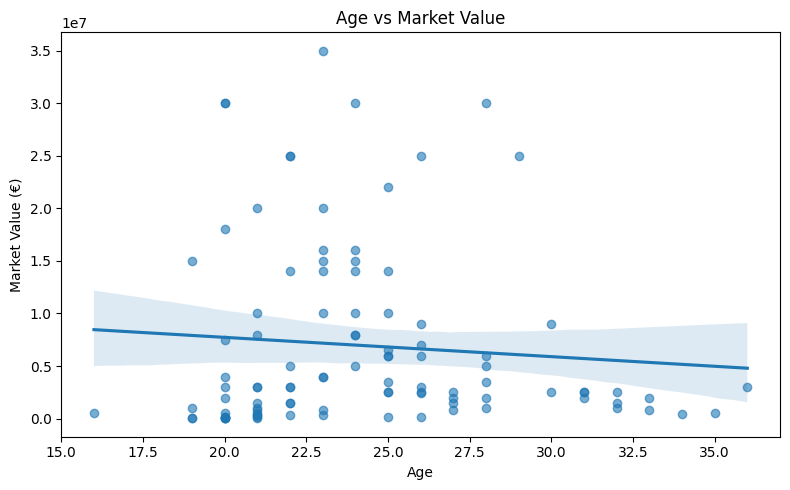

Pearson correlation: -0.088 (p-value: 0.3836)


In [19]:
# Scatterplot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(data=df_clean, x='Age', y='MarketValueEuro', scatter_kws={'alpha': 0.6})
plt.title("Age vs Market Value")
plt.xlabel("Age")
plt.ylabel("Market Value (€)")
plt.tight_layout()
plt.show()

# Calculate Pearson correlation
corr, p_value = pearsonr(df_clean['Age'], df_clean['MarketValueEuro'])
print(f"Pearson correlation: {corr:.3f} (p-value: {p_value:.4f})")

In this dataset, there is a weak negative correlation between age and market value, as age increases, market value tends to slightly decrease, but the relationship is not strong or clearly linear.

In [20]:
# Average market value per position
position_value_df = df_clean.groupby('Position')['MarketValueEuro'].agg(['count', 'mean', 'median']).sort_values('mean', ascending=False)
position_value_df.rename(columns={'count': 'Player Count', 'mean': 'Avg Market Value (€)', 'median': 'Median Market Value (€)'}, inplace=True)
position_value_df

,Player Count,Avg Market Value (€),Median Market Value (€)
Position,,,
Left-Back,7,10785714.29,3000000.00
Defensive Midfield,7,10285714.29,9000000.00
Central Midfield,12,8785416.67,3000000.00
Goalkeeper,12,7993750.00,650000.00
Attacking Midfield,9,7433333.33,5000000.00
Centre-Back,17,7205882.35,3500000.00
Right Winger,10,5180000.00,3000000.00
Left Winger,5,4360000.00,2000000.00
Right-Back,7,4214285.71,3000000.00


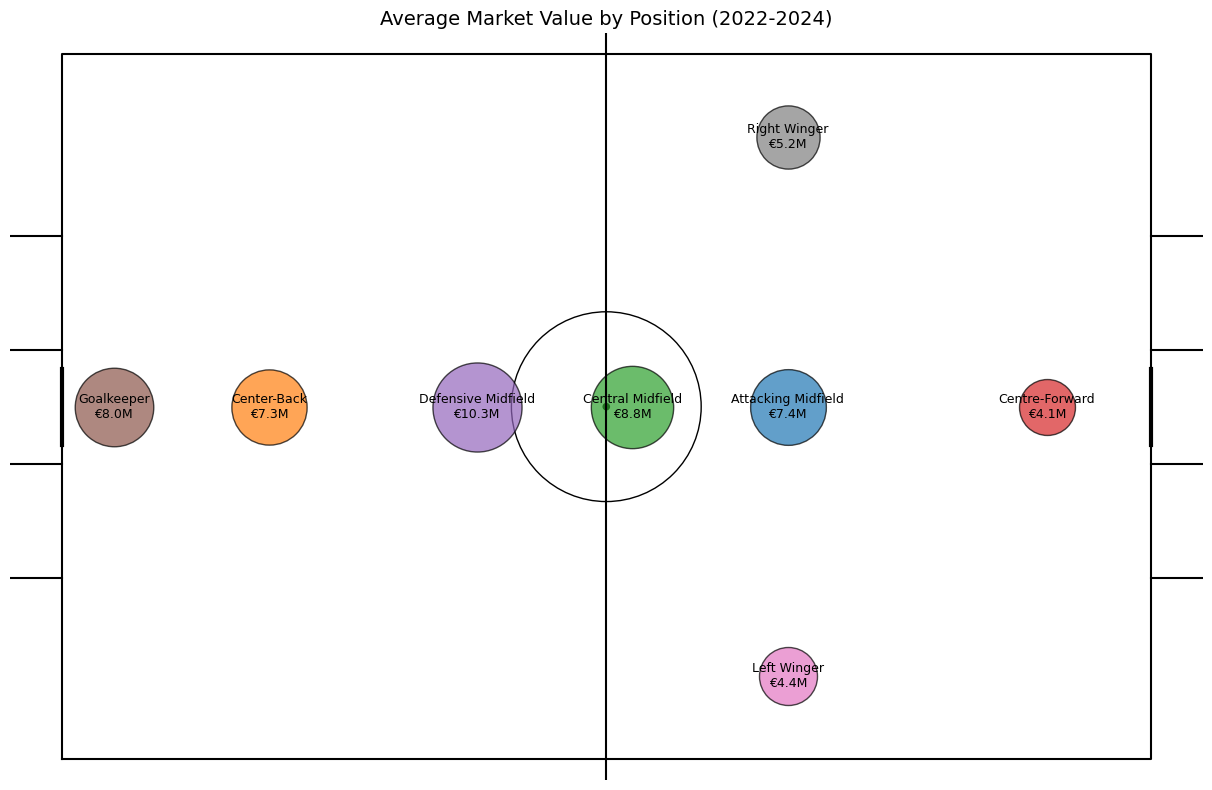

In [21]:
position_coordinates = {
    'Goalkeeper': (5, 34),
    'Right-Back': (20, 60),
    'Left-Back': (20, 8),
    'Center-Back': (20, 34),
    'Defensive Midfield': (40, 34),
    'Central Midfield': (55, 34),
    'Right Midfield': (55, 60),
    'Left Midfield': (55, 8),
    'Attacking Midfield': (70, 34),
    'Right Winger': (70, 60),
    'Left Winger': (70, 8),
    'Second Striker': (80, 34),
    'Centre-Forward': (95, 34),
}

def simplify_position(pos):
    pos = pos.lower()
    if 'goalkeeper' in pos: return 'Goalkeeper'
    elif 'left back' in pos: return 'Left-Back'
    elif 'right back' in pos: return 'Right-Back'
    elif 'back' in pos or 'cb' in pos: return 'Center-Back'
    elif 'defensive' in pos: return 'Defensive Midfield'
    elif 'central' in pos and 'midfield' in pos: return 'Central Midfield'
    elif 'attacking' in pos: return 'Attacking Midfield'
    elif 'winger' in pos and 'left' in pos: return 'Left Winger'
    elif 'winger' in pos and 'right' in pos: return 'Right Winger'
    elif 'striker' in pos or 'forward' in pos: return 'Centre-Forward'
    return 'Unknown'

def draw_pitch(ax=None):
    if ax is None:
        ax = plt.gca()
    
    # Pitch outline & center line
    ax.plot([0, 105, 105, 0, 0], [0, 0, 68, 68, 0], color='black')
    ax.axvline(105 / 2, color='black')

    # Center circle and spot
    center_circle = plt.Circle((105 / 2, 68 / 2), 9.15, color='black', fill=False)
    center_spot = plt.Circle((105 / 2, 68 / 2), 0.3, color='black')
    ax.add_patch(center_circle)
    ax.add_patch(center_spot)

    # Penalty areas, 6-yard boxes, goals, and penalty spots
    for x in [0, 105]:
        sign = 1 if x == 0 else -1
        # Penalty area
        ax.plot([x, x - sign*16.5], [68/2 + 16.5, 68/2 + 16.5], color='black')
        ax.plot([x, x - sign*16.5], [68/2 - 16.5, 68/2 - 16.5], color='black')
        ax.plot([x - sign*16.5, x - sign*16.5], [68/2 - 16.5, 68/2 + 16.5], color='black')
        # Goal area
        ax.plot([x, x - sign*5.5], [68/2 + 5.5, 68/2 + 5.5], color='black')
        ax.plot([x, x - sign*5.5], [68/2 - 5.5, 68/2 - 5.5], color='black')
        ax.plot([x - sign*5.5, x - sign*5.5], [68/2 - 5.5, 68/2 + 5.5], color='black')
        # Penalty spot
        ax.add_patch(plt.Circle((x - sign*11, 68/2), 0.3, color='black'))
        # Goal posts
        ax.plot([x, x], [68/2 - 3.66, 68/2 + 3.66], color='black', linewidth=3)

    ax.set_xlim(-5, 110)
    ax.set_ylim(-2, 70)
    ax.set_aspect('equal')
    ax.axis('off')

# aggregate positions
df_clean['SimplifiedPosition'] = df_clean['Position'].apply(simplify_position)
df_clean = df_clean[df_clean['SimplifiedPosition'].isin(position_coordinates.keys())]
avg_market_values = df_clean.groupby('SimplifiedPosition')['MarketValueEuro'].mean().to_dict()

fig, ax = plt.subplots(figsize=(14, 8))
draw_pitch(ax)

for pos, avg_value in avg_market_values.items():
    x, y = position_coordinates[pos]
    size = avg_value / 1_000_000 * 400
    ax.scatter(x, y, s=size, alpha=0.7, edgecolor='black', linewidth=1)
    ax.text(x, y, f"{pos}\n€{avg_value/1_000_000:.1f}M", fontsize=9, ha='center', va='center')

plt.title("Average Market Value by Position (2022-2024)", fontsize=14)
plt.tight_layout()
plt.show()

In [22]:
def summarize_market_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate summary statistics (min, 25%, 50%, 75%, max) of market value by position and season.
    """
    summary_stats: pd.DataFrame = (
        df.groupby(['Season', 'SimplifiedPosition'])['MarketValueEuro']
        .describe(percentiles=[0.25, 0.5, 0.75])[['min', '25%', '50%', '75%', 'max']]
        .reset_index()
    )
    return summary_stats

market_value_summary: pd.DataFrame = summarize_market_values(df_clean)
market_value_summary

,Season,SimplifiedPosition,min,25%,50%,75%,max
0,2022,Attacking Midfield,14000000.00,15500000.00,17000000.00,18500000.00,20000000.00
1,2022,Center-Back,200000.00,2500000.00,3000000.00,5500000.00,30000000.00
2,2022,Central Midfield,100000.00,800000.00,3000000.00,12000000.00,25000000.00
3,2022,Centre-Forward,50000.00,1600000.00,2500000.00,3500000.00,7000000.00
4,2022,Defensive Midfield,6500000.00,8375000.00,10250000.00,12125000.00,14000000.00
5,2022,Goalkeeper,25000.00,225000.00,400000.00,875000.00,25000000.00
6,2022,Left Winger,16000000.00,16000000.00,16000000.00,16000000.00,16000000.00
7,2022,Right Winger,500000.00,1000000.00,1500000.00,3750000.00,6000000.00
8,2023,Attacking Midfield,100000.00,625000.00,1150000.00,4875000.00,15000000.00
9,2023,Center-Back,300000.00,2000000.00,3000000.00,10500000.00,30000000.00


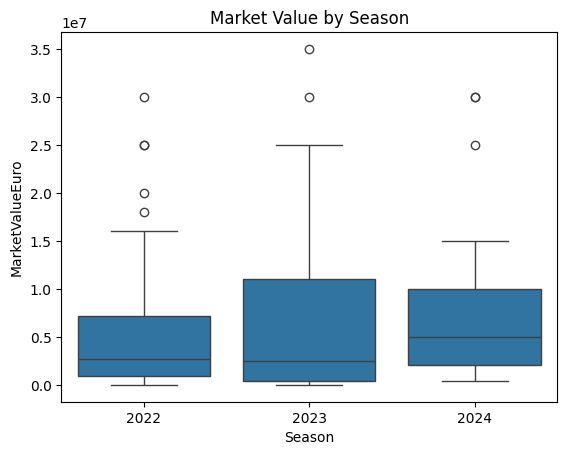

In [23]:
sns.boxplot(data=df_clean, x='Season', y='MarketValueEuro')
plt.title("Market Value by Season")
plt.show()

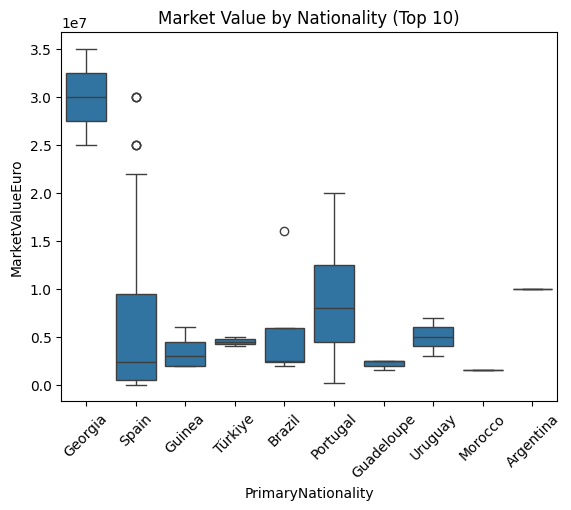

In [24]:
top_nations = df_clean['PrimaryNationality'].value_counts().head(10).index
filtered = df_clean[df_clean['PrimaryNationality'].isin(top_nations)]

sns.boxplot(data=filtered, x='PrimaryNationality', y='MarketValueEuro')
plt.title("Market Value by Nationality (Top 10)")
plt.xticks(rotation=45)
plt.show()

---

## Analysis for Player Javi Guerra

This second section explores an approach to combine the data from the different datasets.
The idea is to create a single dataframe that contains all the data from the different datasets.

In [25]:
# Target name
target_name = "Javi Guerra"
threshold = 85  # Minimum similarity score for a match

# Function to find fuzzy matches
def fuzzy_match_name(df: pd.DataFrame, column_name: str, target: str, threshold: int) -> list[str]:
    matches = []
    for name in df[column_name].astype(str).unique():
        if fuzz.token_sort_ratio(name.lower(), target.lower()) >= threshold:
            matches.append(name)
    return matches

# Search all player DataFrames
print(f"\nFuzzy matching for: '{target_name}' (threshold ≥ {threshold})")

globals_snapshot = {k: v for k, v in globals().items()}
for name, df in globals_snapshot.items():
    if isinstance(df, pd.DataFrame) and name.startswith("df_player_") and 'Player' in df.columns:
        matches = fuzzy_match_name(df, 'Player', target_name, threshold)
        if matches:
            print(f"{name}: Found as - {matches}")
        else:
            print(f"{name}: Not found")


Fuzzy matching for: 'Javi Guerra' (threshold ≥ 85)
df_player_defense_2324: Found as - ['Javier Guerra']
df_player_shooting_2324: Found as - ['Javier Guerra']
df_player_possession_2324: Found as - ['Javier Guerra']
df_player_passing_types_2223: Found as - ['Javier Guerra']
df_player_passing_types_2425: Found as - ['Javier Guerra']
df_player_passing_types_2324: Found as - ['Javier Guerra']
df_player_possession_2223: Found as - ['Javier Guerra']
df_player_possession_2425: Found as - ['Javier Guerra']
df_player_shooting_2425: Found as - ['Javier Guerra']
df_player_shooting_2223: Found as - ['Javier Guerra']
df_player_defense_2223: Found as - ['Javier Guerra']
df_player_defense_2425: Found as - ['Javier Guerra']
df_player_gca_2324: Found as - ['Javier Guerra']
df_player_stats_2223: Found as - ['Javier Guerra']
df_player_stats_2425: Found as - ['Javier Guerra']
df_player_passing_2324: Found as - ['Javier Guerra']
df_player_passing_2425: Found as - ['Javier Guerra']
df_player_passing_2223: F

In [26]:
# Use the fuzzy-matched name instead of the input string
matched_name = "Javier Guerra"

javier_guerra_data: dict[str, pd.DataFrame] = {}

for name, df in globals_snapshot.items():
    if isinstance(df, pd.DataFrame) and name.startswith("df_player_") and 'Player' in df.columns:
        player_rows = df[df['Player'] == matched_name].copy()
        if not player_rows.empty:
            javier_guerra_data[name] = player_rows

# Show summary
for df_name, df_player in javier_guerra_data.items():
    print(f"\n--- {df_name} ---")
    print(df_player.shape)
    display(df_player.head(3))


--- df_player_defense_2324 ---
(1, 21)


,Player,Nation,Pos,Age,90s,Tkl,TklW,Def_3rd,Mid_3rd,Att_3rd,Tkl.1,Att,Tkl%,Lost,Blocks,Sh,Pass,Int,Tkl+Int,Clr,Err
5,Javier Guerra,es ESP,MF,20.00,27.80,54,24,25,22,7,22,58,37.90,36,27,7,20,18,72,44,0



--- df_player_shooting_2324 ---
(1, 22)


,Player,Nation,Pos,Age,90s,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG
5,Javier Guerra,es ESP,MF,20.00,27.80,4,42,14,33.30,1.51,0.50,0.10,0.29,24.30,1,0,0,2.70,2.70,0.06,1.30,1.30



--- df_player_possession_2324 ---
(1, 27)


,Player,Nation,Pos,Age,90s,Touches,Def_Pen,Def_3rd,Mid_3rd,Att_3rd,Att_Pen,Live,Att,Succ,Succ%,Tkld,Tkld%,Carries,TotDist,PrgDist,PrgC,1/3,CPA,Mis,Dis,Rec,PrgR
5,Javier Guerra,es ESP,MF,20.00,27.80,1292,65,291,720,308,22,1292,78,38,48.70,35,44.90,743,4753,2199,47,46,9,50,52,833,68



--- df_player_passing_types_2223 ---
(1, 20)


,Player,Nation,Pos,Age,90s,Att,Live,Dead,FK,TB,Sw,Crs,TI,CK,In,Out,Str,Cmp,Off,Blocks
19,Javier Guerra,es ESP,MF,19.00,6.70,239,233,3,3,0,4,8,0,0,0,0,0,188,3,4



--- df_player_passing_types_2425 ---
(1, 20)


,Player,Nation,Pos,Age,90s,Att,Live,Dead,FK,TB,Sw,Crs,TI,CK,In,Out,Str,Cmp,Off,Blocks
5,Javier Guerra,es ESP,MF,21.00,28.70,1314,1248,55,28,8,11,45,6,15,7,3,0,1023,11,40



--- df_player_passing_types_2324 ---
(1, 20)


,Player,Nation,Pos,Age,90s,Att,Live,Dead,FK,TB,Sw,Crs,TI,CK,In,Out,Str,Cmp,Off,Blocks
5,Javier Guerra,es ESP,MF,20.00,27.80,969,944,21,13,6,12,24,2,0,0,0,0,700,4,31



--- df_player_possession_2223 ---
(1, 27)


,Player,Nation,Pos,Age,90s,Touches,Def_Pen,Def_3rd,Mid_3rd,Att_3rd,Att_Pen,Live,Att,Succ,Succ%,Tkld,Tkld%,Carries,TotDist,PrgDist,PrgC,1/3,CPA,Mis,Dis,Rec,PrgR
19,Javier Guerra,es ESP,MF,19.00,6.70,340,12,57,186,103,15,340,28,14,50.00,13,46.40,211,1406,717,17,10,5,8,20,218,16



--- df_player_possession_2425 ---
(1, 27)


,Player,Nation,Pos,Age,90s,Touches,Def_Pen,Def_3rd,Mid_3rd,Att_3rd,Att_Pen,Live,Att,Succ,Succ%,Tkld,Tkld%,Carries,TotDist,PrgDist,PrgC,1/3,CPA,Mis,Dis,Rec,PrgR
5,Javier Guerra,es ESP,MF,21.00,28.70,1669,65,354,939,401,49,1669,78,29,37.20,45,57.70,927,4925,2585,50,42,13,50,54,1136,84



--- df_player_shooting_2425 ---
(1, 22)


,Player,Nation,Pos,Age,90s,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG
5,Javier Guerra,es ESP,MF,21.00,28.70,3,47,10,21.30,1.64,0.35,0.06,0.30,22.80,1,0,0,2.20,2.20,0.05,0.80,0.80



--- df_player_shooting_2223 ---
(1, 22)


,Player,Nation,Pos,Age,90s,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG
19,Javier Guerra,es ESP,MF,19.00,6.70,1,15,6,40.00,2.23,0.89,0.07,0.17,20.80,0,0,0,0.90,0.90,0.06,0.10,0.10



--- df_player_defense_2223 ---
(1, 21)


,Player,Nation,Pos,Age,90s,Tkl,TklW,Def_3rd,Mid_3rd,Att_3rd,Tkl.1,Att,Tkl%,Lost,Blocks,Sh,Pass,Int,Tkl+Int,Clr,Err
19,Javier Guerra,es ESP,MF,19.00,6.70,16,13,7,4,5,9,20,45.00,11,8,1,7,11,27,9,0



--- df_player_defense_2425 ---
(1, 21)


,Player,Nation,Pos,Age,90s,Tkl,TklW,Def_3rd,Mid_3rd,Att_3rd,Tkl.1,Att,Tkl%,Lost,Blocks,Sh,Pass,Int,Tkl+Int,Clr,Err
5,Javier Guerra,es ESP,MF,21.00,28.70,50,27,18,21,11,26,56,46.40,30,15,3,12,20,70,49,3



--- df_player_gca_2324 ---
(1, 21)


,Player,Nation,Pos,Age,90s,SCA,SCA90,PassLive,PassDead,TO,Sh,Fld,Def,GCA,GCA90,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1
5,Javier Guerra,es ESP,MF,20.00,27.80,46,1.66,33,0,7,3,3,0,1,0.04,0,0,1,0,0,0



--- df_player_stats_2223 ---
(1, 33)


,Player,Nation,Pos,Age,MP,Starts,Min,90s,Gls,Ast,G+A,G-PK,PK,PKatt,CrdY,CrdR,xG,npxG,xAG,npxG+xAG,PrgC,PrgP,PrgR,Gls.1,Ast.1,G+A.1,G-PK.1,G+A-PK,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1
19,Javier Guerra,es ESP,MF,19.00,10,6,605.00,6.70,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.90,0.90,1.10,2.00,17.00,30.00,16.00,0.15,0.00,0.15,0.15,0.15,0.13,0.17,0.30,0.13,0.30



--- df_player_stats_2425 ---
(1, 33)


,Player,Nation,Pos,Age,MP,Starts,Min,90s,Gls,Ast,G+A,G-PK,PK,PKatt,CrdY,CrdR,xG,npxG,xAG,npxG+xAG,PrgC,PrgP,PrgR,Gls.1,Ast.1,G+A.1,G-PK.1,G+A-PK,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1
5,Javier Guerra,es ESP,MF,21.00,36,31,2581.00,28.70,3.00,3.00,6.00,3.00,0.00,0.00,5.00,0.00,2.20,2.20,3.20,5.40,50.00,137.00,84.00,0.10,0.10,0.21,0.10,0.21,0.08,0.11,0.19,0.08,0.19



--- df_player_passing_2324 ---
(1, 28)


,Player,Nation,Pos,Age,90s,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,Cmp.2,Att.2,Cmp%.2,Cmp.3,Att.3,Cmp%.3,Ast,xAG,xA,A-xAG,KP,1/3,PPA,CrsPA,PrgP
5,Javier Guerra,es ESP,MF,20.00,27.80,700,969,72.20,11090,2783,334,415,80.50,288,360,80.00,48,112,42.90,1,0.90,1.90,0.10,12,64,11,2,81



--- df_player_passing_2425 ---
(1, 28)


,Player,Nation,Pos,Age,90s,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,Cmp.2,Att.2,Cmp%.2,Cmp.3,Att.3,Cmp%.3,Ast,xAG,xA,A-xAG,KP,1/3,PPA,CrsPA,PrgP
5,Javier Guerra,es ESP,MF,21.00,28.70,1023,1314,77.90,17160,5349,519,594,87.40,397,466,85.20,87,160,54.40,3,3.20,3.20,-0.20,23,119,23,4,137



--- df_player_passing_2223 ---
(1, 28)


,Player,Nation,Pos,Age,90s,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,Cmp.2,Att.2,Cmp%.2,Cmp.3,Att.3,Cmp%.3,Ast,xAG,xA,A-xAG,KP,1/3,PPA,CrsPA,PrgP
19,Javier Guerra,es ESP,MF,19.00,6.70,188,239,78.70,2919,763,91,107,85.00,76,86,88.40,10,23,43.50,0,1.10,1.70,-1.10,5,15,10,1,30



--- df_player_stats_2324 ---
(1, 33)


,Player,Nation,Pos,Age,MP,Starts,Min,90s,Gls,Ast,G+A,G-PK,PK,PKatt,CrdY,CrdR,xG,npxG,xAG,npxG+xAG,PrgC,PrgP,PrgR,Gls.1,Ast.1,G+A.1,G-PK.1,G+A-PK,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1
5,Javier Guerra,es ESP,MF,20.00,36,28,2498.00,27.80,4.00,1.00,5.00,4.00,0.00,0.00,3.00,1.00,2.70,2.70,0.90,3.60,47.00,81.00,68.00,0.14,0.04,0.18,0.14,0.18,0.10,0.03,0.13,0.10,0.13



--- df_player_gca_2425 ---
(1, 21)


,Player,Nation,Pos,Age,90s,SCA,SCA90,PassLive,PassDead,TO,Sh,Fld,Def,GCA,GCA90,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1
5,Javier Guerra,es ESP,MF,21.00,28.70,74,2.58,56,5,5,4,3,1,6,0.21,4,0,0,2,0,0



--- df_player_gca_2223 ---
(1, 21)


,Player,Nation,Pos,Age,90s,SCA,SCA90,PassLive,PassDead,TO,Sh,Fld,Def,GCA,GCA90,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1
19,Javier Guerra,es ESP,MF,19.00,6.70,18,2.68,12,0,4,1,0,1,0,0.00,0,0,0,0,0,0


In [27]:
# Extract all Javier Guerra rows
player_dfs = {}
target_name = "javier guerra"

for name, df in {k: v for k, v in globals().items()}.items():
    if isinstance(df, pd.DataFrame) and name.startswith("df_player_") and "NormalizedName" in df.columns:
        row = df[df["NormalizedName"] == target_name].copy()
        if not row.empty:
            player_dfs[name] = row

In [28]:
player_dfs = {}
target_name = "javier guerra"

for name, df in {k: v for k, v in globals().items()}.items():
    if isinstance(df, pd.DataFrame) and name.startswith("df_player_") and "Player" in df.columns:
        df["NormalizedName"] = df["Player"].str.lower().str.strip()
        row = df[df["NormalizedName"] == target_name].copy()
        if not row.empty:
            player_dfs[name] = row.drop(columns=["NormalizedName"])

In [29]:
def extract_stat_table(player_dfs, data_type: str, field_mapping: dict) -> pd.DataFrame:
    results = []

    for name, df in player_dfs.items():
        if data_type in name:
            season = name.split("_")[-1]
            row = df.iloc[0]
            entry = {"Season": season}
            for label, fbref_col in field_mapping.items():
                entry[label] = row.get(fbref_col, None)
            results.append(entry)

    return pd.DataFrame(results).sort_values("Season").reset_index(drop=True)

In [30]:
# General overview
overview_fields = {
    "Age": "Age",
    "Minutes": "Min",
    "90s": "90s",
    "Games": "MP",
    "Starts": "Starts",
    "Goals": "Gls",
    "Assists": "Ast"
}
df_overview = extract_stat_table(player_dfs, "stats", overview_fields)

# Shooting
shooting_fields = {
    "Shots": "Sh",
    "Shots/90": "Sh/90",
    "SoT%": "SoT%",
    "xG": "xG",
    "G": "Gls",
    "G - xG": "G-xG"
}
df_shooting = extract_stat_table(player_dfs, "shooting", shooting_fields)

# Passing
passing_fields = {
    "Passes Attempted": "Att",
    "Passes Completed": "Cmp",
    "Cmp%": "Cmp%",
    "Progressive Passes": "PrgP",
    "Key Passes": "KP",
    "xAG": "xAG"
}
df_passing = extract_stat_table(player_dfs, "passing", passing_fields)

# Possession
possession_fields = {
    "Touches": "Touches",
    "Carries": "Carries",
    "Progressive Carries": "PrgC",
    "Miscontrols": "Mis",
    "Dispossessed": "Dis"
}
df_possession = extract_stat_table(player_dfs, "possession", possession_fields)

# Defense
defense_fields = {
    "Tackles": "Tkl",
    "Interceptions": "Int",
    "Tackles + Int": "Tkl+Int",
    "Blocks": "Blocks",
    "Clearances": "Clr"
}
df_defense = extract_stat_table(player_dfs, "defense", defense_fields)

In [31]:
df_overview.head()

,Season,Age,Minutes,90s,Games,Starts,Goals,Assists
0,2223,19.00,605.00,6.70,10,6,1.00,0.00
1,2324,20.00,2498.00,27.80,36,28,4.00,1.00
2,2425,21.00,2581.00,28.70,36,31,3.00,3.00


In [32]:
df_shooting.head()

,Season,Shots,Shots/90,SoT%,xG,G,G - xG
0,2223,15,2.23,40.00,0.90,1,0.10
1,2324,42,1.51,33.30,2.70,4,1.30
2,2425,47,1.64,21.30,2.20,3,0.80


In [33]:
df_passing.head()

,Season,Passes Attempted,Passes Completed,Cmp%,Progressive Passes,Key Passes,xAG
0,2223,239,188,NaN,NaN,NaN,NaN
1,2223,239,188,78.70,30.00,5.00,1.10
2,2324,969,700,NaN,NaN,NaN,NaN
3,2324,969,700,72.20,81.00,12.00,0.90
4,2425,1314,1023,NaN,NaN,NaN,NaN


In [34]:
df_possession.head()

,Season,Touches,Carries,Progressive Carries,Miscontrols,Dispossessed
0,2223,340,211,17,8,20
1,2324,1292,743,47,50,52
2,2425,1669,927,50,50,54


In [35]:
df_defense.head()

,Season,Tackles,Interceptions,Tackles + Int,Blocks,Clearances
0,2223,16,11,27,8,9
1,2324,54,18,72,27,44
2,2425,50,20,70,15,49


---

In [36]:
# Ensure no duplicates before merging
for df_name, df in [
    ("df_overview", df_overview),
    ("df_shooting", df_shooting),
    ("df_passing", df_passing),
    ("df_possession", df_possession),
    ("df_defense", df_defense),
]:
    if not df["Season"].is_unique:
        df.drop_duplicates(subset="Season", keep="last", inplace=True)

# Merge all datasets into one season-level overview
df_combined = df_overview.copy()
df_combined = (
    df_combined
    .merge(df_shooting, on="Season", how="left")
    .merge(df_passing, on="Season", how="left")
    .merge(df_possession, on="Season", how="left")
    .merge(df_defense, on="Season", how="left")
)

# Ensure Minutes and 90s are float
df_combined["Minutes"] = df_combined["Minutes"].astype(float)
df_combined["90s"] = df_combined["Minutes"] / 90

# Optional: drop exact duplicate rows
df_combined = df_combined.drop_duplicates(subset="Season", keep="last").reset_index(drop=True)

df_combined.head()

,Season,Age,Minutes,90s,Games,Starts,Goals,Assists,Shots,Shots/90,SoT%,xG,G,G - xG,Passes Attempted,Passes Completed,Cmp%,Progressive Passes,Key Passes,xAG,Touches,Carries,Progressive Carries,Miscontrols,Dispossessed,Tackles,Interceptions,Tackles + Int,Blocks,Clearances
0,2223,19.00,605.00,6.72,10,6,1.00,0.00,15,2.23,40.00,0.90,1,0.10,239,188,78.70,30.00,5.00,1.10,340,211,17,8,20,16,11,27,8,9
1,2324,20.00,2498.00,27.76,36,28,4.00,1.00,42,1.51,33.30,2.70,4,1.30,969,700,72.20,81.00,12.00,0.90,1292,743,47,50,52,54,18,72,27,44
2,2425,21.00,2581.00,28.68,36,31,3.00,3.00,47,1.64,21.30,2.20,3,0.80,1314,1023,77.90,137.00,23.00,3.20,1669,927,50,50,54,50,20,70,15,49


In [37]:
df_clean.head()

,Rank,Name,Position,Age,Nationality,Current club,Season,MarketValueEuro,PrimaryNationality,SimplifiedPosition
0,25.00,Giorgi Mamardashvili,Goalkeeper,22,Georgia,Valencia CF,2022,25000000.00,Georgia,Goalkeeper
1,23.00,Jaume Doménech,Goalkeeper,32,Spain,Valencia CF,2022,1000000.00,Spain,Goalkeeper
2,1.00,Iago Herrerín,Goalkeeper,35,Spain,Sestao River,2022,500000.00,Spain,Goalkeeper
3,42.00,Emilio Bernad,Goalkeeper,23,Spain,Racing Ferrol,2022,300000.00,Spain,Goalkeeper
4,13.00,Cristian Rivero,Goalkeeper,25,Spain,Albacete Balompié,2022,200000.00,Spain,Goalkeeper


In [38]:
# Filter df_clean for Javi Guerra (strict match)
df_javi_clean = df_clean[df_clean["Name"].str.strip().str.lower() == "javi guerra"]

# Convert season to FBref format (2022 to "2223")
df_javi_clean["Season"] = df_javi_clean["Season"].astype(int)
df_javi_clean["Season"] = df_javi_clean["Season"].apply(lambda x: f"{str(x)[-2:]}{str(x+1)[-2:]}")
df_javi_clean["Season"] = df_javi_clean["Season"].astype(str)

# Ensure both sides use string season keys
df_combined["Season"] = df_combined["Season"].astype(str)

# Merge (add Market Value and other metadata)
df_combined = df_combined.merge(
    df_javi_clean,
    on="Season",
    how="left",
    suffixes=("", "_javi")
)

df_combined[["Season", "Name", "Age", "MarketValueEuro", "Position", "Current club", "Games", "Shots/90"]]

,Season,Name,Age,MarketValueEuro,Position,Current club,Games,Shots/90
0,2223,Javi Guerra,19.00,2000000.00,Central Midfield,Valencia CF,10,2.23
1,2324,Javi Guerra,20.00,20000000.00,Central Midfield,Valencia CF,36,1.51
2,2425,Javi Guerra,21.00,25000000.00,Central Midfield,NaN,36,1.64


Ideas on next steps:

* Merge all season-level player performance data and market values into one dataset per player-season
* Filter for players with at least two consecutive seasons to enable forecasting
* Shift the market value by one season to use current-season stats to predict next-season value
* Engineer features from player stats (goals, minutes, passes, etc) and metadata (age, position, club)
* Use all players (not just our Javi example) to train a general model that can predict future market value from current-season performance
* Split train/test chronologically to simulate real-world forecasting
* Train regression models (e.g. XGBoost, Random Forest) to predict market value one year ahead
* Evaluate performance using MAE/MAPE and compare predictions to real market values for the next season
* Once validated, use the model to forecast future market values based on current stats for any player